In [4]:
from scipy.io import loadmat
import glob
from sklearn.naive_bayes import GaussianNB

import numpy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [1]:
ls /data/lisa/data/neuro/Meditation/time-series/cortex/

monk01_rest.mat       monk05_rest.mat       monk09_rest.mat
monk01_samatha.mat    monk05_samatha.mat    monk09_samatha.mat
monk01_vipassana.mat  monk05_vipassana.mat  monk09_vipassana.mat
monk02_rest.mat       monk06_rest.mat       monk10_rest.mat
monk02_samatha.mat    monk06_samatha.mat    monk10_samatha.mat
monk02_vipassana.mat  monk06_vipassana.mat  monk10_vipassana.mat
monk03_rest.mat       monk07_rest.mat       monk11_rest.mat
monk03_samatha.mat    monk07_samatha.mat    monk11_samatha.mat
monk03_vipassana.mat  monk07_vipassana.mat  monk11_vipassana.mat
monk04_rest.mat       monk08_rest.mat       monk12_rest.mat
monk04_samatha.mat    monk08_samatha.mat    monk12_samatha.mat
monk04_vipassana.mat  monk08_vipassana.mat  monk12_vipassana.mat


In [2]:
states = ['rest', 'samatha', 'vipassana']

# single monk

## time series shapes

In [4]:
d = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk01_%s.mat'
                % field)
    d[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


## raw time series

Raw time series for state rest


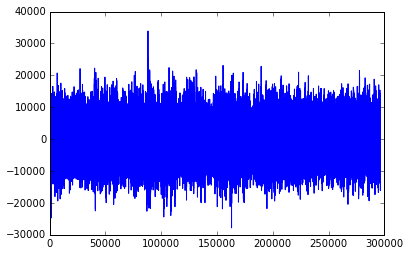

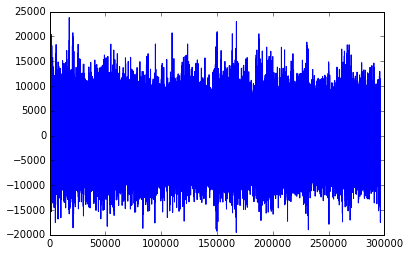

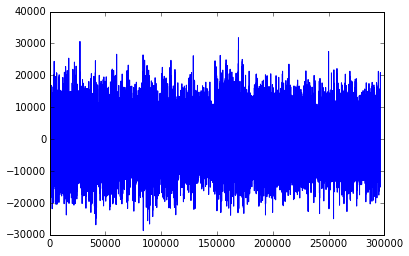

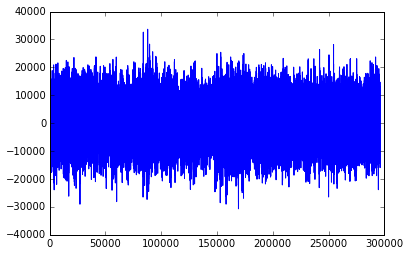

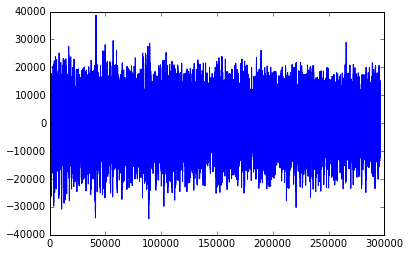

(296418,)


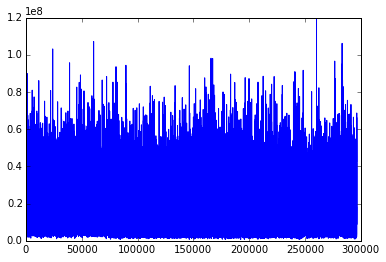

Raw time series for state samatha


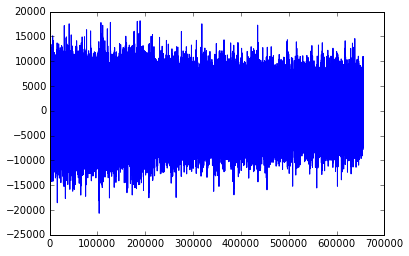

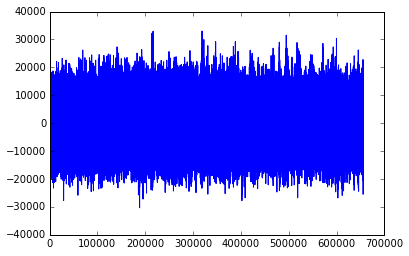

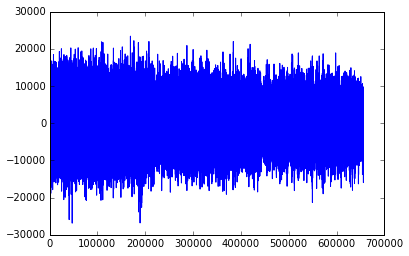

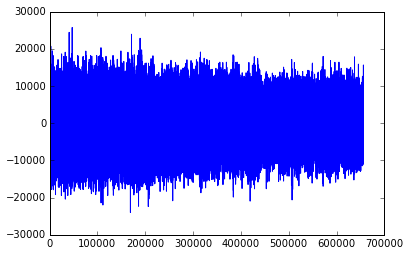

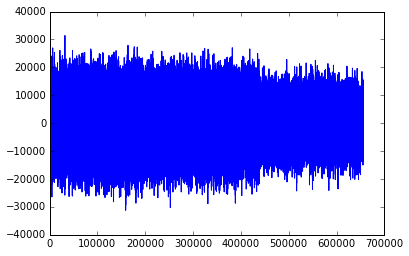

(656286,)


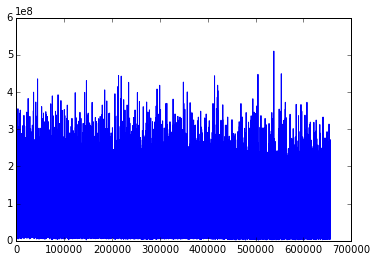

Raw time series for state vipassana


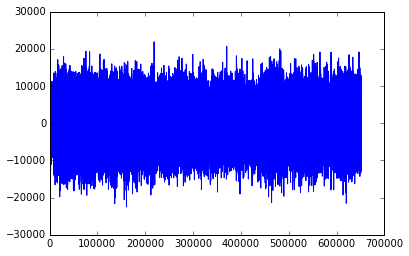

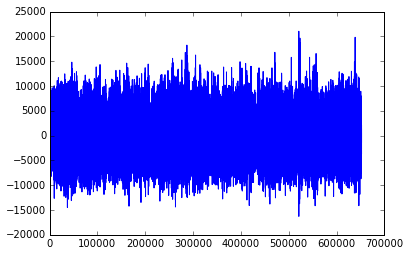

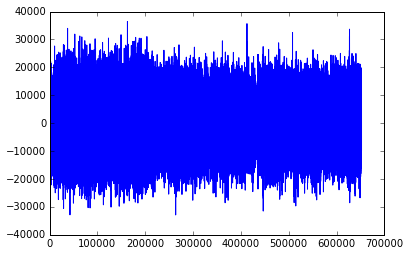

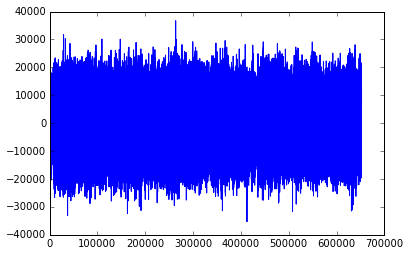

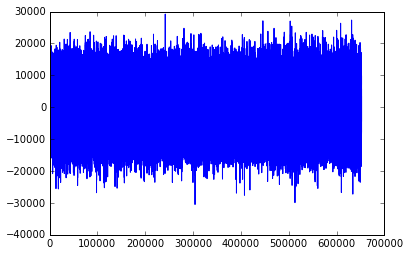

(652199,)


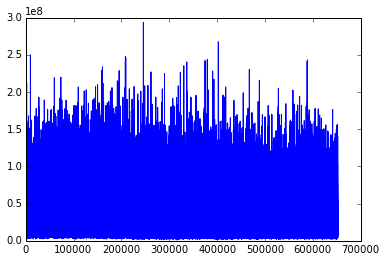

In [14]:
for field in ['rest', 'samatha', 'vipassana']:
    print 'Raw time series for state %s' % field
    for i in range(5):
        plt.plot(d[field][i,:])
        plt.show()
        
    diff = ((d[field][:,1:] - d[field][:,:-1]) ** 2).mean(axis=0)
    print diff.shape
    plt.plot(diff)
    plt.show()

## spectrograms

Spectrograms for state rest


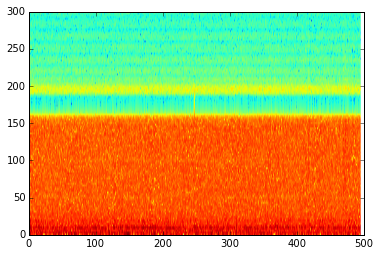

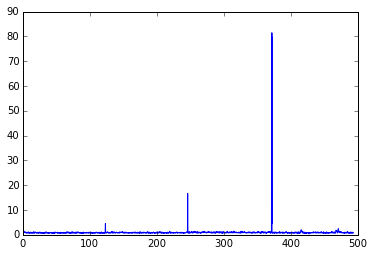

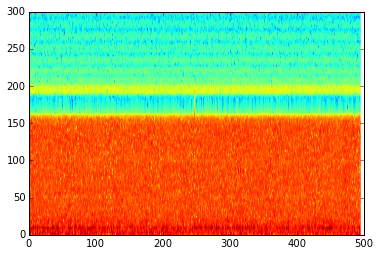

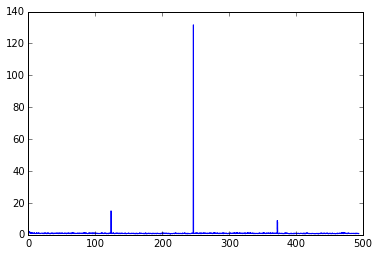

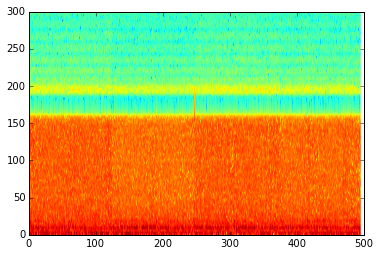

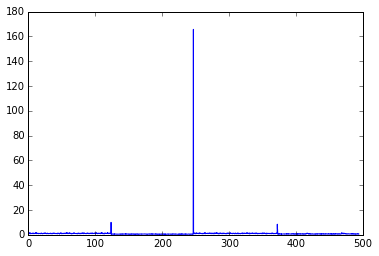

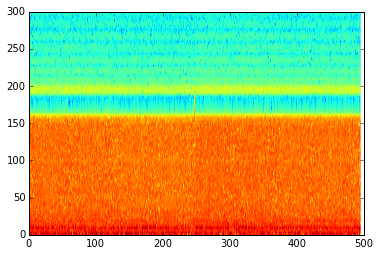

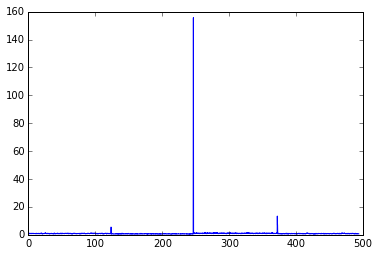

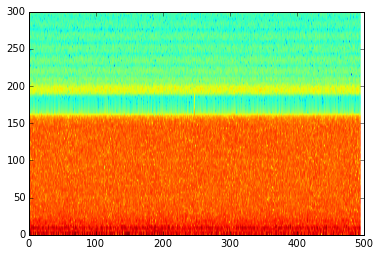

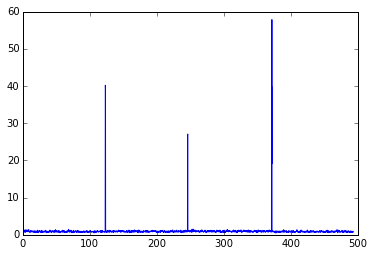

Spectrograms for state samatha


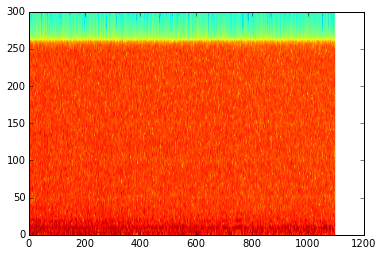

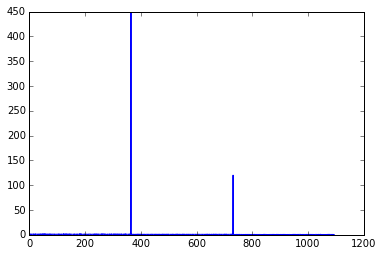

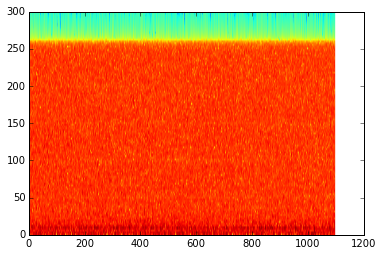

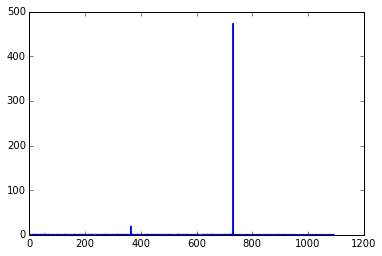

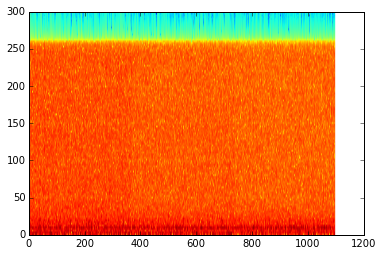

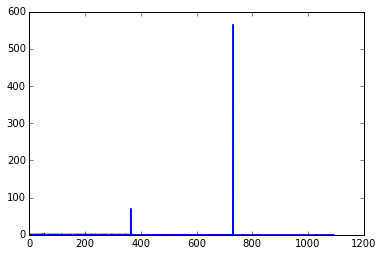

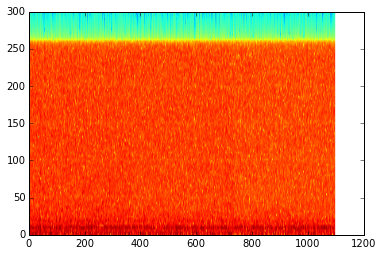

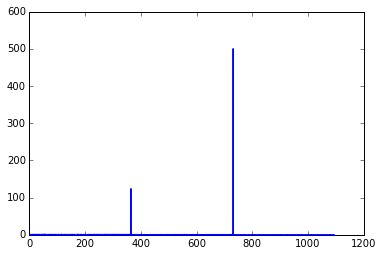

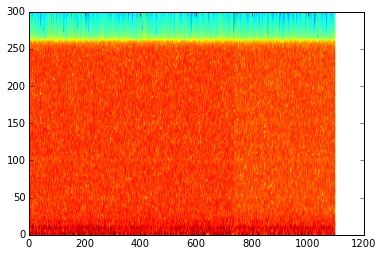

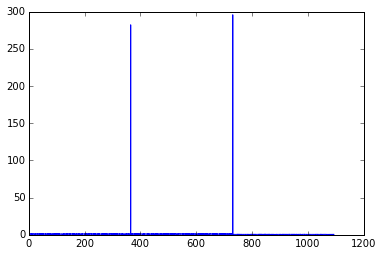

Spectrograms for state vipassana


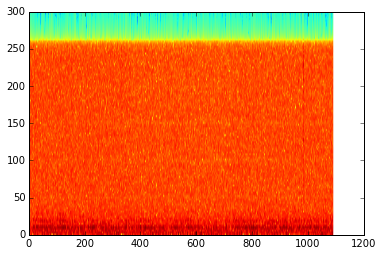

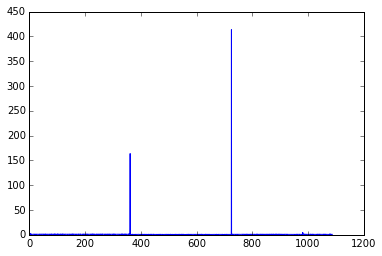

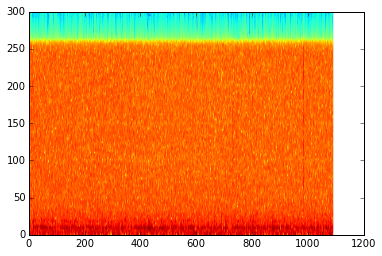

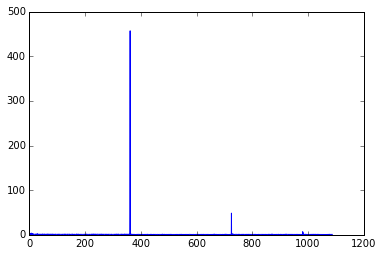

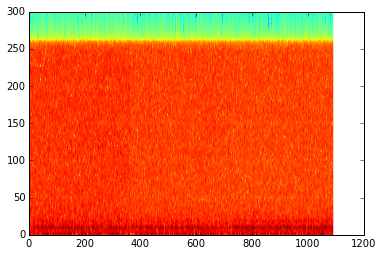

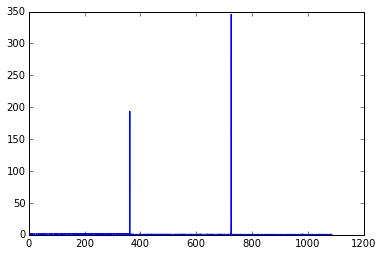

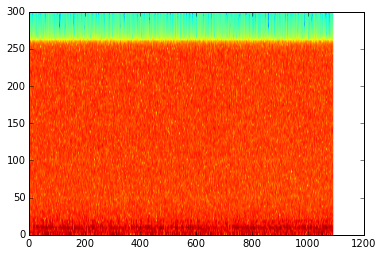

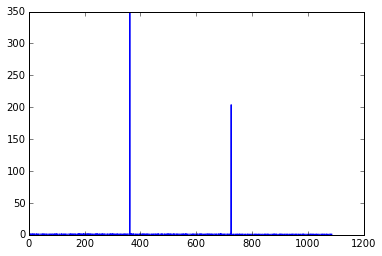

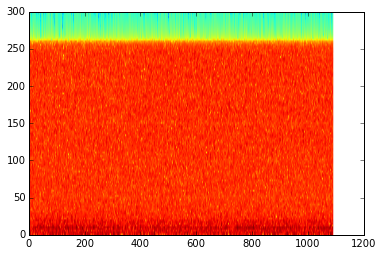

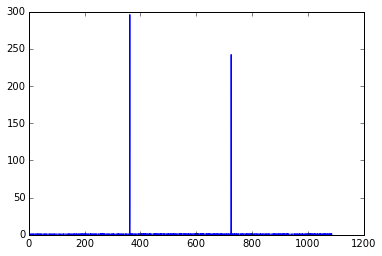

In [5]:
for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    for i in range(5):
        s, fs, ts, _ = plt.specgram(d[field][i,:], Fs=600)
        diff = (numpy.abs(s[:,1:] - s[:,:-1]) / s.mean(axis=1, keepdims=True)).mean(axis=0)
        plt.show()
        plt.plot(ts[:-1], diff)
        plt.show()

## classification using power features for a single sensor

first we build a tensor of size (timesteps x number of sensor x freqs) for each state

In [6]:
features_dict = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d[field].shape[0]):
        s, fs, ts = mlab.specgram(d[field][i,:], Fs=600)
        features.append(s)
    features_dict[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict[field].shape

Spectrograms for state rest
(2314, 148, 129)
Spectrograms for state samatha
(5126, 148, 129)
Spectrograms for state vipassana
(5094, 148, 129)


for each sensor, train a classifier and print its score on a valid set

In [7]:
indices = numpy.arange(sum([features_dict[f].shape[0] for f in states]))
numpy.random.shuffle(indices)

targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets = targets[indices]

train = slice(0, 10000)
test = slice(10000, len(indices))

for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    
    features = features[indices]
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features[train], targets[train])
    y_pred_train = y_fit.predict(features[train])
    y_pred_test = y_fit.predict(features[test])
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets[train]).sum()) / 10000,
    print float((y_pred_test != targets[test]).sum()) / (test.stop - test.start)

Misclassified for sensor 0: 0.2267 0.234806629834
Misclassified for sensor 1: 0.0024 0.00118389897395
Misclassified for sensor 2: 0.0287 0.0323599052881
Misclassified for sensor 3: 0.0208 0.017363851618
Misclassified for sensor 4: 0.25 0.257695343331
Misclassified for sensor 5: 0.1714 0.176006314128
Misclassified for sensor 6: 0.2604 0.256906077348
Misclassified for sensor 7: 0.2721 0.274664561957
Misclassified for sensor 8: 0.0054 0.00710339384373
Misclassified for sensor 9: 0.0032 0.00315706393054
Misclassified for sensor 10: 0.001 0.000394632991318
Misclassified for sensor 11: 0.0338 0.0355169692186
Misclassified for sensor 12: 0.1348 0.140094711918
Misclassified for sensor 13: 0.2221 0.219021310182
Misclassified for sensor 14: 0.1339 0.137332280979
Misclassified for sensor 15: 0.0027 0.0043409629045
Misclassified for sensor 16: 0.03 0.0268350434096
Misclassified for sensor 17: 0.0332 0.0280189423836
Misclassified for sensor 18: 0.2726 0.267166535122
Misclassified for sensor 19: 0.2

# inter monk

Experimental results

| Monk        | Sensor with best accuracy | Misclassification rate for this sensor  |
|:------------:|:-------------:|:-----:|
| 2 | 147 | .001  |
| 3 | 126 | 0.013 |
| 4 | 10  | 0.23  |
| 5 | 94  | 0.12  |
| 6 | 141 | 0.24  |
| 7 | 131 | 0.037 |
| 8 | 94  | 0.16  |

In [8]:
d2 = dict()
for field in ['rest', 'samatha', 'vipassana']:
    d1 = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk08_%s.mat'
                % field)
    d2[field] = d1['F']
    print field, d[field].shape

rest (148, 296419)
samatha (148, 656287)
vipassana (148, 652200)


In [9]:
features_dict2 = dict()

for field in ['rest', 'samatha', 'vipassana']:
    print 'Spectrograms for state %s' % field
    features = []
    for i in range(d2[field].shape[0]):
        s, fs, ts = mlab.specgram(d2[field][i,:], Fs=600)
        features.append(s)
    features_dict2[field] = numpy.rollaxis(numpy.array(features), 2)
    print features_dict2[field].shape

Spectrograms for state rest
(4401, 148, 129)
Spectrograms for state samatha
(5254, 148, 129)
Spectrograms for state vipassana
(5069, 148, 129)


In [10]:
targets = numpy.array([0] * features_dict['rest'].shape[0]
                      + [1] * features_dict['samatha'].shape[0]
                      + [2] * features_dict['vipassana'].shape[0])
targets2 = numpy.array([0] * features_dict2['rest'].shape[0]
                       + [1] * features_dict2['samatha'].shape[0]
                       + [2] * features_dict2['vipassana'].shape[0])


for sensor in range(features_dict['rest'].shape[1]):
    features = numpy.concatenate([
            features_dict['rest'][:,sensor,:],
            features_dict['samatha'][:,sensor,:],
            features_dict['vipassana'][:,sensor,:],
        ], axis=0)
    features_test = numpy.concatenate([
        features_dict2['rest'][:,sensor,:],
        features_dict2['samatha'][:,sensor,:],
        features_dict2['vipassana'][:,sensor,:],
    ], axis=0)
    
    gnb = GaussianNB()
    y_fit = gnb.fit(features, targets)
    y_pred_train = y_fit.predict(features)
    y_pred_test = y_fit.predict(features_test)
    
    print 'Misclassified for sensor %d:' % (sensor, ),
    print float((y_pred_train != targets).sum()) / len(targets),
    print float((y_pred_test != targets2).sum()) / len(targets2)

Misclassified for sensor 0: 0.227780437211 0.402336321652
Misclassified for sensor 1: 0.00215414073719 0.342705786471
Misclassified for sensor 2: 0.0299186213499 0.486688399891
Misclassified for sensor 3: 0.0205042284985 0.221882640587
Misclassified for sensor 4: 0.251077070369 0.341415376256
Misclassified for sensor 5: 0.172251475985 0.345218690573
Misclassified for sensor 6: 0.258656454444 0.354998641673
Misclassified for sensor 7: 0.274932184458 0.347324096713
Misclassified for sensor 8: 0.00590394127972 0.449470252649
Misclassified for sensor 9: 0.00311153662039 0.804808475958
Misclassified for sensor 10: 0.000877612892931 0.43289866884
Misclassified for sensor 11: 0.0339077708633 0.233767997827
Misclassified for sensor 12: 0.135391734482 0.487842977452
Misclassified for sensor 13: 0.22155736397 0.372928552024
Misclassified for sensor 14: 0.134194989628 0.273634881826
Misclassified for sensor 15: 0.00303175363013 0.248166259169
Misclassified for sensor 16: 0.030237753311 0.34494702

# leave one monk out

In [6]:
data = []
field_to_target = {'rest':0, 'samatha':1, 'vipassana':2}

for monk in range(1, 13):
    print 'monk', monk
    features = []
    targets = []
    for field in ['rest', 'samatha', 'vipassana']:
        this_features = []
        d = loadmat('/data/lisa/data/neuro/Meditation/time-series/cortex/monk%.2d_%s.mat'
            % (monk, field))['F']
        for i in range(d.shape[0]):
            s, fs, ts = mlab.specgram(d[i,:], Fs=600, NFFT=512)
            this_features.append(s[:129,:])
        
        # (n_sensors, frequencies, timestamps)
        this_features = numpy.array(this_features)
        print this_features.shape
        
        features.append(this_features)    
        targets.append(numpy.array([field_to_target[field]] * s.shape[1]))
    
    data.append((numpy.concatenate(features, axis=2), numpy.concatenate(targets, axis=0)))
    print data[-1][0].shape
    print data[-1][1].shape
    
del features, targets, this_features, s

monk 1
(148, 129, 771)
(148, 129, 1708)
(148, 129, 1698)
(148, 129, 4177)
(4177,)
monk 2
(148, 129, 1027)
(148, 129, 1655)
(148, 129, 1677)
(148, 129, 4359)
(4359,)
monk 3
(148, 129, 992)
(148, 129, 1653)
(148, 129, 1637)
(148, 129, 4282)
(4282,)
monk 4
(148, 129, 1334)
(148, 129, 906)
(148, 129, 993)
(148, 129, 3233)
(3233,)
monk 5
(148, 129, 1343)
(148, 129, 1705)
(148, 129, 1706)
(148, 129, 4754)
(4754,)
monk 6
(148, 129, 854)
(148, 129, 1702)
(148, 129, 1710)
(148, 129, 4266)
(4266,)
monk 7
(148, 129, 1073)
(148, 129, 1723)
(148, 129, 1702)
(148, 129, 4498)
(4498,)
monk 8
(148, 129, 1467)
(148, 129, 1751)
(148, 129, 1689)
(148, 129, 4907)
(4907,)
monk 9
(148, 129, 1006)
(148, 129, 1646)
(148, 129, 1653)
(148, 129, 4305)
(4305,)
monk 10
(148, 129, 851)
(148, 129, 1119)
(148, 129, 1676)
(148, 129, 3646)
(3646,)
monk 11
(148, 129, 754)
(148, 129, 1665)
(148, 129, 1617)
(148, 129, 4036)
(4036,)
monk 12
(148, 129, 673)
(148, 129, 1664)
(148, 129, 1666)
(148, 129, 4003)
(4003,)


In [9]:
for monk_out in range(1, 13):
    print 'I will leave monk %d out' % (monk_out)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for monk in range(1, 13):
        if monk == monk_out:
            test_x.append(data[monk-1][0])
            test_y.append(data[monk-1][1])
        else:
            train_x.append(data[monk-1][0])
            train_y.append(data[monk-1][1])
        
    train_x = numpy.concatenate(train_x, axis=2)
    train_y = numpy.concatenate(train_y, axis=0)
    train_x = train_x.reshape(-1, train_x.shape[2]).transpose()
    test_x = numpy.concatenate(test_x, axis=2)
    test_y = numpy.concatenate(test_y, axis=0)
    test_x = test_x.reshape(-1, test_x.shape[2]).transpose()
    
    gnb = GaussianNB()
    
    y_fit = gnb.fit(train_x, train_y)
    y_pred_train = y_fit.predict(train_x)
    y_pred_test = y_fit.predict(test_x)
    
    print 'Misclassified for monk %d:' % (monk_out, ),
    print float((y_pred_train != train_y).sum()) / len(train_y),
    print float((y_pred_test != test_y).sum()) / len(test_y)

I will leave monk 1 out
Misclassified for monk 1: 0.378037978785 0.5152022983
I will leave monk 2 out
Misclassified for monk 2: 0.350705966556 0.634319798119
I will leave monk 3 out
Misclassified for monk 3: 0.348107569721 0.985287248949
I will leave monk 4 out
Misclassified for monk 4: 0.373658247412 0.776678008042
I will leave monk 5 out
Misclassified for monk 5: 0.35413020651 0.71539755995
I will leave monk 6 out
Misclassified for monk 6: 0.354632034632 0.767932489451
I will leave monk 7 out
Misclassified for monk 7: 0.322833275322 0.7563361494
I will leave monk 8 out
Misclassified for monk 8: 0.348383414913 0.659873649888
I will leave monk 9 out
Misclassified for monk 9: 0.364095231906 0.831823461092
I will leave monk 10 out
Misclassified for monk 10: 0.35055531824 0.713933077345
I will leave monk 11 out
Misclassified for monk 11: 0.386991169502 0.937314172448
I will leave monk 12 out
Misclassified for monk 12: 0.302821599983 0.861104171871
